# initial notebook for connectivity using gdal_proximity
- needs xarray-spatial, not avaliable in datacube
- can make venvs, but for below just cloned repo (https://github.com/makepath/xarray-spatial/tree/master)
- binary layer of wofs, items, mangrove, saltmarsh, (mudflats?)

In [29]:
%matplotlib inline

import sys
from osgeo import gdal
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd

sys.path.insert(0, "/home/jovyan/code/dea-notebooks/Tools")
import datacube
from dea_tools.plotting import display_map
from datacube.utils.cog import write_cog
from datacube.utils.geometry import Geometry
from dea_tools.spatial import xr_rasterize
from datacube.testutils.io import rio_slurp_xarray
dc = datacube.Datacube()


sys.path.insert(1, "/home/jovyan/code/xarray-spatial")
from xrspatial.proximity import proximity

# load virtual product
import importlib
from datacube.virtual import catalog_from_file
from datacube.virtual import DEFAULT_RESOLVER
catalog = catalog_from_file('../virtual_products/virtual_product_cat_wcf.yaml')

In [4]:
# add time (not a range, just repeat year input here)
time_range = ("2020", "2020")

# export as geotiff?
export = True

In [5]:
# GA coastal tiles
vector_file = '../data/geojson/ga_summary_grid_c3_coastal.geojson'
attribute_col = 'geometry'

gdf = gpd.read_file(vector_file)
mainland_grid = gdf[gdf['type'] == 'mainland']

id_list = []
for index, row in mainland_grid.iterrows():
    id_list.append(row['id'])
mainland_grid.explore()

In [6]:
gdf = mainland_grid.loc[mainland_grid['id'] == 286]

In [7]:
gdf.explore()

In [8]:
# Create the 'query' dictionary object
res = (-30, 30)

query = {
    "time": time_range,
    'resolution':res}

In [9]:
# Loop through polygons in geodataframe and add geom to queries
for index, row in gdf.iterrows():
    print(f'Feature: {index + 1}/{len(gdf)}')
    
    # Extract the feature's geometry as a datacube geometry object
    geom = Geometry(geom=row.geometry, crs=gdf.crs)
    
    # Update the query to include our geopolygon
    query.update({'geopolygon': geom})

# Extracting specific keys from dictionary (removing time to load things like item and srtm)
query_notime = {key: query[key] for key in query.keys()
       & {'resolution', 'geopolygon'}}

Feature: 286/1


In [53]:
# Load in water (could do from wofs as well)
lc = dc.load(product="ga_ls_landcover_class_cyear_2", output_crs="EPSG:3577", measurements=["level3"], **query)

# get water class
water = (lc.level3 == 220)
water = xr.where((water == True), 1, 0).astype('int8')


# Load ITEMs
item_ds = dc.load(product = 'item_v2', output_crs="EPSG:3577", **query_notime)
item = item_ds.relative
intertidal = item > 0


# Load in mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', output_crs="EPSG:3577", **query)

# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(item), coords=item.coords, dims=item.dims, attrs=item.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)
    

# Load in saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'

# load in geotiff again but with identical extent from landcover
saltmarsh = rio_slurp_xarray(geotiff_path, gbox=lc.geobox)
saltmarsh.attrs['crs'] = 'EPSG:3577'

# Generate a polygon mask to keep only data within the polygon
# mask = xr_rasterize(gdf.iloc[[index]], lc)

# # Mask dataset to set pixels outside the polygon to `NaN`
# saltmarsh = saltmarsh.where(mask)


# Load in saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'

# load in geotiff again but with identical extent from landcover
saltflat = rio_slurp_xarray(geotiff_path, gbox=lc.geobox)
saltflat.attrs['crs'] = 'EPSG:3577'

# # Generate a polygon mask to keep only data within the polygon
# mask = xr_rasterize(gdf.iloc[[index]], lc)

# # Mask dataset to set pixels outside the polygon to `NaN`
# saltflat = saltflat.where(mask)

In [54]:
# item (remove all intertidal areas)

# remove time dim
water = water.squeeze('time')
intertidal = intertidal.squeeze('time')
mangrove = mangrove.squeeze('time')


In [63]:
# combine masks
# intertidal not included here but I'm pretty sure its in level 3 220 for water
aquatic = xr.where((water == True) | (mangrove == True) | (saltmarsh == True) | (saltflat == True), 1, 0).astype('int8')

In [65]:
# Generate a polygon mask to keep only data within the polygon
mask = xr_rasterize(gdf, item_ds)

# Mask dataset to set pixels outside the polygon to `NaN`
aquatic = aquatic.where(mask)

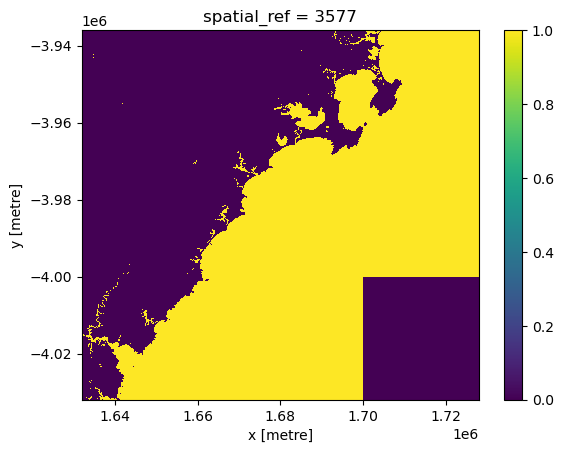

In [66]:
aquatic.plot()

In [67]:
# xrspatial proximity - https://xarray-spatial.org/reference/_autosummary/xrspatial.proximity.proximity.html
# seems it is in same units as crs (EPSG3577 = metres)
proximity_agg = proximity(aquatic)
proximity_agg

<xarray.DataArray (y: 3201, x: 3201)>
array([[ 3911.5215 ,  3886.2449 ,  3861.0361 , ...,    30.     ,
           30.     ,    30.     ],
       [ 3895.4973 ,  3870.1162 ,  3844.8018 , ...,     0.     ,
            0.     ,     0.     ],
       [ 3879.6392 ,  3854.1536 ,  3828.7334 , ...,     0.     ,
            0.     ,     0.     ],
       ...,
       [  960.4686 ,   930.48376,   900.4999 , ..., 27930.     ,
        27960.     , 27990.     ],
       [  961.87317,   931.9335 ,   901.9978 , ..., 27930.     ,
        27960.     , 27990.     ],
       [  964.20953,   934.34467,   904.48883, ..., 27930.     ,
        27960.     , 27990.     ]], dtype=float32)
Coordinates:
  * y            (y) float64 -3.936e+06 -3.936e+06 ... -4.032e+06 -4.032e+06
  * x            (x) float64 1.632e+06 1.632e+06 ... 1.728e+06 1.728e+06
    spatial_ref  int32 3577

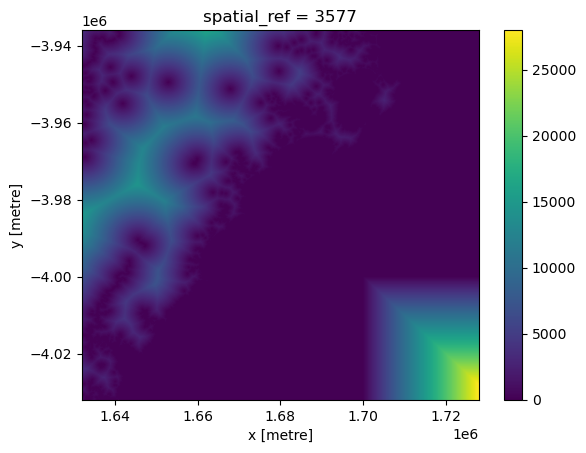

In [68]:
proximity_agg.plot()

In [69]:
# Find the minimum and maximum values in the data array
min_value = proximity_agg.min()
max_value = proximity_agg.max()

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
normalized_data = (proximity_agg - min_value) / (max_value - min_value)

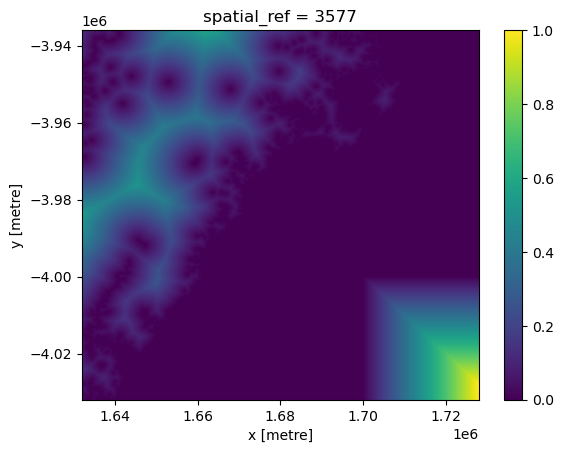

In [70]:
normalized_data.plot()